In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.io as scio
import folium
from folium.plugins import HeatMap
import math
import bisect
import os
import json
import torch
from tqdm import tqdm
from tqdm.std import trange
import copy
import cv2

In [2]:
########################### Create Dataset New!!!
class datasetItem:
    def __init__(self, index):
        self.index = index
        self.global_id = None
        self.img_path = ''
        self.img_shape = None
        self.lanes = []
        self.prob = []
        self.solid_prob = []
        self.solid_type = []

def to_dataset(data, # input
               dataset # output
              ):
    file_unreaded = True
    data_item_idx = 0

    print('to create dataset')

    for idx, index in tqdm( enumerate(data['index']) ):
        points = []
        if index == 0 and file_unreaded: # file not readed, first lane of image

            file_unreaded = False
            data_item = datasetItem(data_item_idx)
            data_item.global_id = data['global_id'][idx]
            data_item.img_path  = data['img'][idx]
            data_item.img_shape = (data['img_width'][idx], data['img_height'][idx])

            data_item.lanes.append(json.loads(data['points'][idx]))
            data_item.prob.append(data['prob'][idx])
            data_item.solid_prob.append(data['solid_prob'][idx])
            data_item.solid_type.append(data['solid_type'][idx])

            dataset.append(data_item) # create new item
            
        elif index == 0 and not file_unreaded: # file readed, first lane of image

            data_item = datasetItem(data_item_idx)
            data_item.global_id = data['global_id'][idx]
            data_item.img_path  = data['img'][idx]
            data_item.img_shape = (data['img_width'][idx], data['img_height'][idx])

            data_item.lanes.append(json.loads(data['points'][idx]))
            data_item.prob.append(data['prob'][idx])
            data_item.solid_prob.append(data['solid_prob'][idx])
            data_item.solid_type.append(data['solid_type'][idx])

            dataset.append(data_item) # create new item
            
        else: # following lanes of image
            dataset[-1].lanes.append(json.loads(data['points'][idx]))
            dataset[-1].prob.append(data['prob'][idx])
            dataset[-1].solid_prob.append(data['solid_prob'][idx])
            dataset[-1].solid_type.append(data['solid_type'][idx])
    print('done')

In [33]:
root = "exp/oct23/inference/aicom_lane_test/bkp/"
label_csv = os.path.join(root, "inf_out_rank_0.csv")
data = pd.read_csv(label_csv, index_col=False) #data frame
data.head(5)

,global_id,img,index,img_width,img_height,prob,solid_prob,solid_type,points
0,0,LB-XL_1656_20131022_135119_f007440_fc00026770_...,0,1280,720,1.0,1.0,solid,"[[653.4002697467805, 339.1875], [627.940316372..."
1,0,LB-XL_1656_20131022_135119_f007440_fc00026770_...,1,1280,720,1.0,1.0,solid,"[[651.5005457401277, 348.18749999999994], [635..."
2,0,LB-XL_1656_20131022_135119_f007440_fc00026770_...,2,1280,720,1.0,1.0,solid,"[[676.390279531479, 348.18749999999994], [679...."
3,0,LB-XL_1656_20131022_135119_f007440_fc00026770_...,3,1280,720,1.0,1.0,solid,"[[767.2223615646363, 366.18749999999994], [807..."
4,1,LB-XL_814_20131011_144531_f000990_fc00053070_.bmp,0,1280,720,1.0,1.0,solid,"[[658.0066466331482, 357.1875], [648.956339394..."


In [34]:
csv_data=list()
for i in range(4):
    label_csv = os.path.join(root, "inf_out_rank_{}.csv".format(i))
    csv_data.append( pd.read_csv(label_csv, index_col=False) )


In [35]:
# merge csv data
datasets = []
for i in range(4):
    items = []
    to_dataset(csv_data[i], items)
    
    datasets.extend(items)
# print('dataset len: {}'.format( [len(i) for i in datasets] ) )

254it [00:00, 2537.84it/s]

to create dataset


47879it [00:08, 5392.44it/s]
673it [00:00, 6724.70it/s]

done
to create dataset


47944it [00:08, 5368.19it/s]
692it [00:00, 6915.03it/s]

done
to create dataset


47900it [00:07, 6794.42it/s]
0it [00:00, ?it/s]

done
to create dataset


47914it [00:09, 5162.50it/s]

done


In [38]:
len(datasets)

54207

In [39]:
def refine(ln, degree=90): # ln: list of [x,y]
    i=2 # 0,1
    
    while True:
        if i >= len(ln):
            break
            
        x1, y1 = ln[i-2][0], ln[i-2][1]
        x2, y2 = ln[i-1][0], ln[i-1][1]
        x3, y3 = ln[i][0], ln[i][1]
        
        vec1 = np.array([x2-x1, y2-y1])
        vec2 = np.array([x3-x2, y3-y2])
        n1 = np.linalg.norm(vec1)
        n2 = np.linalg.norm(vec2)
        vec1 = vec1 / n1
        vec2 = vec2 / n2
        
        d = np.dot(vec1, vec2)
        
        if d <= np.cos(np.radians(degree)): # bad p3
                del ln[i]
        i += 1
        
    return ln

In [27]:
# reserve orig dataset:
dataset_orig = copy.deepcopy(datasets)

In [41]:
dataset = datasets
for it in tqdm(dataset):
    for lid, ln in enumerate(it.lanes):
        tmp = refine(ln)
        if len(tmp) <= 3:
            del it.lanes[lid]
        else:
            it.lanes[lid] = tmp

for i, it in tqdm(enumerate(dataset)):
    if len(it.lanes) <= 0:
        print(i)

100%|██████████| 54207/54207 [02:46<00:00, 325.97it/s]
54207it [00:00, 380897.29it/s]

22598
53510


In [46]:
dataset[-1].global_id, len(dataset)

(54222, 54206)

In [ ]:
outputs_dict = torch.load("exp/oct20/inference/aicom_lane_test/oct22_debug.pth", 
                          map_location=torch.device("cpu")) # oct22 oct20 aicom
test_imgs = outputs_dict["test_images"]

In [47]:
img_id = 0
no_id = []
# for i, img in enumerate(test_imgs):
for i in range( len(dataset) ):
    temp_id = dataset[i].global_id
    while img_id != temp_id:
        no_id.append(img_id)
        img_id += 1
        
    
    if img_id == temp_id:
        img_id += 1
print(no_id)

[9912, 11485, 14057, 14084, 14590, 14980, 18335, 24732, 33799, 40649, 42114, 43209, 48798, 49021, 49492, 50299, 54011]


In [66]:
for i in no_id:
    img = test_imgs[i].split('/')[-1]
    
    data_item = datasetItem(i)
    data_item.global_id = i
    data_item.img_path  = img
    data_item.img_shape = (1280,720)

    data_item.lanes.append([[1,1],[2,2]])
    data_item.prob.append(1.0)
    data_item.solid_prob.append(1.0)
    data_item.solid_type.append('solid')

    dataset.append(data_item) # create new item

In [67]:
for i, it in enumerate(dataset):
    if len(it.lanes) == 0:
        print(i, it.img_path)
        it.lanes.append([[1,1],[2,2]])


In [50]:
# Write csv
epoch = 300

img = []
index = []
img_width = []
img_height = []
lane_prob = []
solid_prob = []
points = []
solid_type = []
for it in tqdm(dataset):
    for lid, ln in enumerate(it.lanes):
        img.append( it.img_path )
        index.append( lid )
        img_width.append(1280)
        img_height.append(720)
        lane_prob.append( 1.0 )
        solid_prob.append( 1.0 )
        solid_type.append( 'solid' )
        ln = [[int(pt[0]), int(pt[1])] for pt in ln]
        points.append( ln )

cont_list = {'img':img, 'index':index, 'img_width':img_width, 'img_height':img_height,
         'prob':lane_prob,'solid_prob':solid_prob, 'solid_type':solid_type,'points':points}
df = pd.DataFrame(cont_list)
df.to_csv('./out/res_it_{}_refined.csv'.format(epoch, epoch), index=False)

100%|██████████| 54206/54206 [00:07<00:00, 7698.46it/s] 


In [81]:
def line_dist(l):
    rx, ry = 1280/512., 720/256.
    dist = np.sqrt( (l[0][0] - l[-1][0])**2 + (l[0][1] - l[-1][1])**2 )
    return dist

In [ ]:
dataset_sorted = sorted(dataset, key=lambda it: it.global_id)

784.2887798820333
414.6467739183401
139.78904433917774


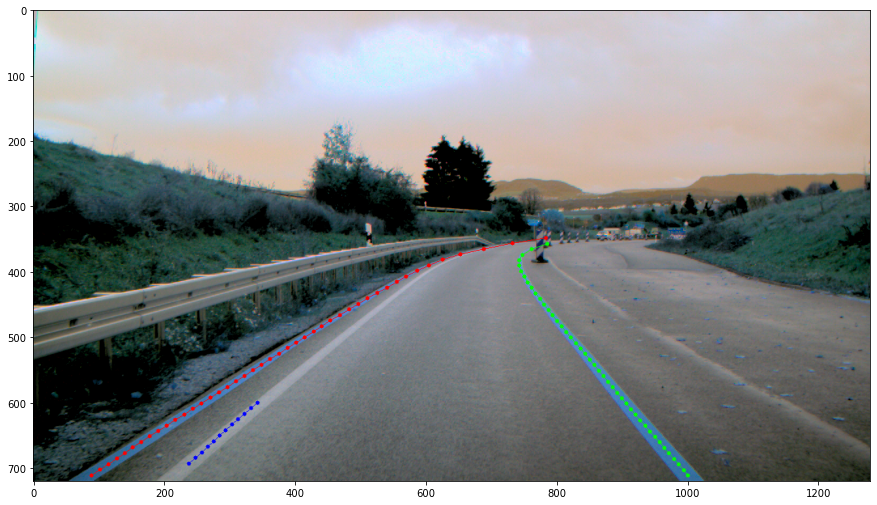

In [82]:
########################### Show samples of Dataset

import matplotlib.pyplot as plt
color = [(255,0,0), (0,255,0),(0,0,255),\
         (255,255,0),(255,0,255),(0,255,255),(255,255,255),\
         (100,255,0),(100,0,255),(255,100,0),(0,100,255),(255,0,100),(0,255,100),(0,0,0)]

# 53235 13122 53237 24049 53235 47154 7994 7995 45315 161 2570 2739 7
# 45315 47154
idx = 46000
temp_data_item = dataset_sorted[idx]

img = cv2.imread('datasets/lane_detection/test/images/'+temp_data_item.img_path)

for idx, pts in enumerate(temp_data_item.lanes):
    # print([(int(pt[0]), int(pt[1])) for pt in pts])
    print( line_dist(pts) )
    for i in range(len(pts)-1):
        x1 = int(pts[i][0])
        y1 = int(pts[i][1])
        x2 = int(pts[i+1][0])
        y2 = int(pts[i+1][1])
        cv2.circle(img, (x1,y1), 3, color[idx], -1)
        cv2.circle(img, (x2,y2), 3, color[idx], -1)
        cv2.line(img, (x1,y1), (x2,y2), color[idx], 1)

            
plt.figure(figsize=(15, 15))
plt.imshow(img)

plt.show() 

In [84]:
79 * 2.5

197.5